In [1]:
%load_ext autoreload
%autoreload 2

# Proof of concept

In [2]:
# Torch device management
import torch

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


In [5]:
import embedders

In [6]:
# Load Polblogs

polblogs_dists, polblogs_labels = embedders.dataloaders.load(
    "polblogs",
    labels=True,
    polblogs_path="/Users/phil/embedders/data/graphs/polblogs.mtx",
    polblogs_labels_path="/Users/phil/embedders/data/graphs/polblogs_labels.tsv",
)

Top CC has 1222 nodes; original graph has 1490 nodes.


In [10]:
# Specify signature - useful to re-initialize the manifold here

torch.manual_seed(0)  # Not all seeds are stable - this one trains for 3000 iterations at lr=1e-2 (burn-in 1e-3)

signature = [(-1, 6)]
pm = embedders.manifolds.ProductManifold(signature=signature)
print(pm.name)

# Rescale distances
dists_rescaled = polblogs_dists / polblogs_dists.max()

# Get embedding
embedders.coordinate_learning.train_coords(
    pm,
    dists_rescaled,
    device=device,
    burn_in_iterations=300,
    training_iterations=300 * 9,
    learning_rate=1e-1,
    burn_in_learning_rate=1e-2,
    scale_factor_learning_rate=1e-1,
)

h6_polblogs = pm.x_embed.detach().cpu().numpy()

H_1.0^6


  0%|          | 0/3000 [00:00<?, ?it/s]

In [22]:
# Compare productDT and sklearn on this dataset
# from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# from hyperdt.tree import HyperbolicDecisionTreeClassifier
from embedders.tree_new import ProductSpaceDT
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(h6_polblogs, polblogs_labels.values, test_size=0.2, random_state=0)

pdt = ProductSpaceDT(pm=pm, max_depth=3, use_special_dims=True)
pdt.fit(X_train, y_train)
pdt_f1 = f1_score(y_test, pdt.predict(X_test))
print(f"ProductDT\t{pdt_f1*100:.2f}")

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
dt_f1 = f1_score(y_test, dt.predict(X_test))
print(f"DT\t{dt_f1*100:.2f}")

ProductDT	89.23
DT	89.31


In [23]:
# Same thing, but now we do H2 x E2 x S2
torch.manual_seed(0)

signature = [(-1, 2), (0, 2), (1, 2)]
pm2 = embedders.manifolds.ProductManifold(signature=signature)
print(pm2.name)

# Get embedding
embedders.coordinate_learning.train_coords(
    pm2,
    dists_rescaled,
    device=device,
    burn_in_iterations=300,
    training_iterations=300 * 9,
    learning_rate=1e-1,
    burn_in_learning_rate=1e-2,
    scale_factor_learning_rate=1e-1,
)

h2_e2_s2_polblogs = pm2.x_embed.detach().cpu().numpy()

H_1.0^2 x E_0.0^2 x S_1.0^2


  0%|          | 0/3000 [00:00<?, ?it/s]

In [24]:
# Compare productDT and sklearn on this dataset
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(
    h2_e2_s2_polblogs, polblogs_labels.values, test_size=0.2, random_state=0
)

pdt2 = ProductSpaceDT(pm=pm2, max_depth=3)
pdt2.fit(X_train, y_train)
pdt2_f1 = f1_score(y_test, pdt2.predict(X_test))
print(f"ProductDT\t{pdt2_f1*100:.2f}")

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
dt_f1 = f1_score(y_test, dt.predict(X_test))
print(f"DT\t{dt_f1*100:.2f}")
# cv_eval(dt, "DT", h2_e2_s2_polblogs, polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

ProductDT	90.57
DT	88.46


In [10]:
# Does it hold up componentwise?

# Hyperbolic
pdt_H = ProductSpaceDT(max_depth=3, signature=[(2, -1.0)])
cv_eval(pdt_H, "ProductDT (H)", h2_e2_s2_polblogs[:, pm2.man2dim[0]], polblogs_labels)

hdt_H = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=True)
cv_eval(hdt_H, "HyperDT (H)", h2_e2_s2_polblogs[:, pm2.man2dim[0]], polblogs_labels)

dt_H = DecisionTreeClassifier(max_depth=3)
cv_eval(dt_H, "DT (H)", h2_e2_s2_polblogs[:, pm2.man2dim[0]], polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

print()

# Euclidean
# For the euclidean ones, we won't use man2dim because fix_X() breaks it - we'll hardcode 3:6 instead
pdt_E = ProductSpaceDT(max_depth=3, signature=[(2, 0.0)])
cv_eval(pdt_E, "ProductDT (E)", fix_X(h2_e2_s2_polblogs)[:, 3:6], polblogs_labels)

dt_E = DecisionTreeClassifier(max_depth=3)
cv_eval(dt_E, "DT (E)", h2_e2_s2_polblogs[:, pm2.man2dim[1]], polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

print()

# Sphere
pdt_S = ProductSpaceDT(max_depth=3, signature=[(2, 1.0)])
cv_eval(pdt_S, "ProductDT (S)", h2_e2_s2_polblogs[:, pm2.man2dim[2]], polblogs_labels)

hdt_S = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=True, angle_midpoint_method="bisect")
cv_eval(hdt_S, "HyperDT (S)", h2_e2_s2_polblogs[:, pm2.man2dim[2]], polblogs_labels)

dt_S = DecisionTreeClassifier(max_depth=3)
cv_eval(dt_S, "DT (S)", h2_e2_s2_polblogs[:, pm2.man2dim[2]], polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

ProductDT (H)	70.13 +/- 2.41
HyperDT (H)	70.13 +/- 2.41
DT (H)	68.98 +/- 3.30

ProductDT (E)	81.34 +/- 4.06
DT (E)	81.34 +/- 4.06

ProductDT (S)	90.26 +/- 1.02
HyperDT (S)	90.26 +/- 1.02
DT (S)	90.67 +/- 1.59


In [54]:
contributions = embedders.metrics.dist_component_by_manifold(pm2, pm2.x_embed)

# Why don't these add to 100%...?
print(contributions)
print(sum(contributions))

[0.25659456849098206, 0.3267468214035034, 0.4166586697101593]
1.0000000596046448


# Exhaustive benchmark

In [25]:
SIGNATURES = [
    [(-1, 10)],
    [(0, 10)],
    [(1, 10)],
    [(-1, 5), (-1, 5)],
    [(1, 5), (1, 5)],
    [(-1, 5), (1, 5)],
    [(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)],
    [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
    [(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)],
]

In [36]:
import torch
import embedders
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [37]:
# Get data

polblogs_dists, polblogs_labels = embedders.dataloaders.load(
    "polblogs",
    labels=True,
    polblogs_path="/Users/phil/embedders/data/graphs/polblogs.mtx",
    polblogs_labels_path="/Users/phil/embedders/data/graphs/polblogs_labels.tsv",
)
dists_rescaled = polblogs_dists / polblogs_dists.max()
dists_rescaled = torch.tensor(dists_rescaled, dtype=torch.float32).to(device)
polblogs_labels = torch.tensor(polblogs_labels.values, dtype=torch.long).to(device)

Top CC has 1222 nodes; original graph has 1490 nodes.


In [43]:
from embedders.tree import TorchProductSpaceDT, TorchProductSpaceRF
from embedders.metrics import d_avg
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import pickle
import os

DOWNSAMPLE = None
ITERS = 3_000
TRIALS = 10

results = []
for i, signature in enumerate(SIGNATURES):
    for j in range(TRIALS):
        # Skip existing
        if os.path.exists(f"../data/polblogs_embeddings/polblogs_{i}_{j}.npy"):
            continue

        seed = i * TRIALS + j  # Unique seed
        torch.manual_seed(seed)

        # Generate embedding
        pm = embedders.manifolds.ProductManifold(signature=signature).to(device)
        embedders.coordinate_learning.train_coords(
            pm,
            dists_rescaled[:DOWNSAMPLE, :DOWNSAMPLE],
            device=device,
            burn_in_iterations=int(ITERS * 0.1),
            training_iterations=int(ITERS * 0.9),
            learning_rate=1e-1,
            burn_in_learning_rate=1e-2,
            scale_factor_learning_rate=1e-2,
        )

        # Save embeddings
        np.save(
            f"../data/polblogs_embeddings/polblogs_{i}_{j}.npy",
            pm.x_embed.detach().cpu().numpy(),
        )

        # Calculate d_avg
        my_d_avg = d_avg(pm.pdist(pm.x_embed), dists_rescaled[:DOWNSAMPLE, :DOWNSAMPLE]).item()

        # Results should just be average distances
        results.append({"signature": signature, "seed": seed, "d_avg": my_d_avg})

results = pd.DataFrame(results)
results.to_csv("../data/polblogs_embeddings/dists.tsv", sep="\t")

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [68]:
# Run benchmarks
import torch
import pandas as pd
from tqdm.notebook import tqdm

# Params
TRIALS = 10
MAX_DEPTH = 5
SCORE = "f1-micro"

# Get data
_, y = embedders.dataloaders.load(
    "polblogs",
    labels=True,
    polblogs_path="/Users/phil/embedders/data/graphs/polblogs.mtx",
    polblogs_labels_path="/Users/phil/embedders/data/graphs/polblogs_labels.tsv",
)
y = torch.tensor(y.values)

# Benchmark loop
results = []
with torch.no_grad():
    my_tqdm = tqdm(total=TRIALS * len(SIGNATURES))
    for i, signature in enumerate(SIGNATURES):
        pm = embedders.manifolds.ProductManifold(signature=signature)
        for j in range(TRIALS):
            X = np.load(f"../data/polblogs_embeddings/polblogs_{i}_{j}.npy")
            X = torch.tensor(X)
            if X.isnan().any():
                print(i, j, "NaN")
                break

            # Run benchmarks
            seed = i * TRIALS + j
            accs = embedders.benchmarks.benchmark(
                X, y, pm, max_depth=MAX_DEPTH, task="classification", score=SCORE, seed=seed
            )
            accs["signature"] = signature
            accs["seed"] = seed
            results.append(accs)

            my_tqdm.update(1)

results = pd.DataFrame(results)

Top CC has 1222 nodes; original graph has 1490 nodes.


  0%|          | 0/90 [00:00<?, ?it/s]

0 4 NaN


In [69]:
results

,sklearn_dt,sklearn_rf,product_dt,product_rf,tangent_dt,tangent_rf,knn,ps_perceptron,signature,seed
0,0.946939,0.946939,0.942857,0.934694,0.942857,0.942857,0.926531,0.469388,"[(-1, 10)]",0
1,0.926531,0.922449,0.930612,0.938776,0.926531,0.934694,0.942857,0.489796,"[(-1, 10)]",1
2,0.938776,0.963265,0.942857,0.951020,0.934694,0.955102,0.946939,0.481633,"[(-1, 10)]",2
3,0.938776,0.963265,0.938776,0.967347,0.934694,0.959184,0.963265,0.453061,"[(-1, 10)]",3
4,0.885714,0.934694,0.889796,0.951020,0.889796,0.934694,0.938776,0.506122,"[(0, 10)]",10
...,...,...,...,...,...,...,...,...,...,...
79,0.934694,0.946939,0.934694,0.942857,0.934694,0.934694,0.942857,0.481633,"[(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)]",85
80,0.918367,0.930612,0.893878,0.926531,0.902041,0.914286,0.922449,0.453061,"[(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)]",86
81,0.897959,0.914286,0.848980,0.893878,0.906122,0.930612,0.938776,0.514286,"[(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)]",87
82,0.930612,0.955102,0.938776,0.951020,0.934694,0.946939,0.946939,0.632653,"[(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)]",88


In [80]:
results.drop("signature", axis=1).mean()

sklearn_dt        0.922303
sklearn_rf        0.939990
product_dt        0.918902
product_rf        0.924198
tangent_dt        0.922449
tangent_rf        0.938047
knn               0.940185
ps_perceptron     0.490719
seed             47.214286
dtype: float64

In [83]:
results["signature"] = [str(sig) for sig in results["signature"]]  # Idempotent
results_grouped = results.groupby(["signature"]).mean()
results_grouped

,sklearn_dt,sklearn_rf,product_dt,product_rf,tangent_dt,tangent_rf,knn,ps_perceptron,seed
signature,,,,,,,,,
"[(-1, 10)]",0.937755,0.948980,0.938776,0.947959,0.934694,0.947959,0.944898,0.473469,1.5
"[(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)]",0.913878,0.931837,0.919184,0.909796,0.918367,0.931837,0.930204,0.475102,64.5
"[(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)]",0.923265,0.935510,0.914286,0.919184,0.920816,0.935918,0.935510,0.486939,84.5
"[(-1, 5), (-1, 5)]",0.928980,0.944082,0.924898,0.935918,0.927755,0.941633,0.948163,0.487347,34.5
"[(-1, 5), (1, 5)]",0.935918,0.949796,0.920408,0.914286,0.935510,0.943265,0.942449,0.528980,54.5
"[(0, 10)]",0.922857,0.940000,0.924898,0.938776,0.922449,0.940000,0.943265,0.486939,14.5
"[(1, 10)]",0.908163,0.929388,0.898367,0.909388,0.904490,0.931837,0.933469,0.486531,24.5
"[(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)]",0.917959,0.941224,0.929388,0.934286,0.915510,0.940000,0.944490,0.488163,74.5
"[(1, 5), (1, 5)]",0.921224,0.944490,0.911837,0.922449,0.929796,0.935918,0.942041,0.492653,44.5


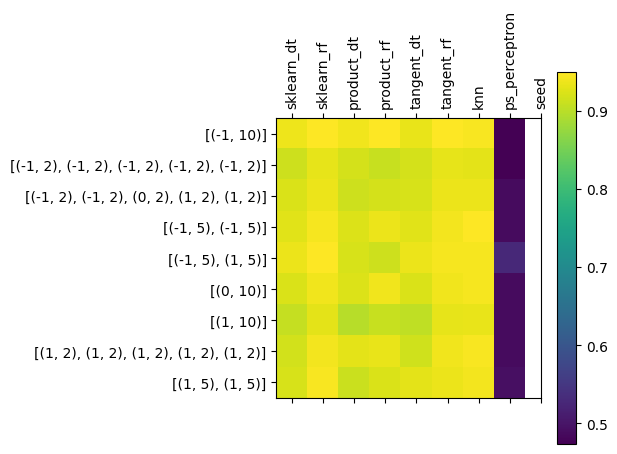

In [91]:
plt.matshow(results_grouped.drop("seed", axis=1).values)
plt.yticks(range(len(results_grouped.index)), results_grouped.index)
plt.xticks(range(len(results_grouped.columns)), results_grouped.columns, rotation=90)
plt.colorbar()
plt.show()

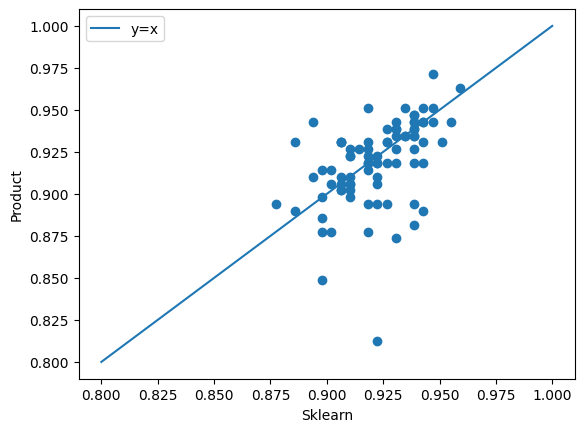

In [75]:
import matplotlib.pyplot as plt

plt.scatter(results["sklearn_dt"], results["product_dt"])
plt.xlabel("Sklearn")
plt.ylabel("Product")
plt.plot([0.8, 1], [0.8, 1], label="y=x")
plt.legend()

plt.show()

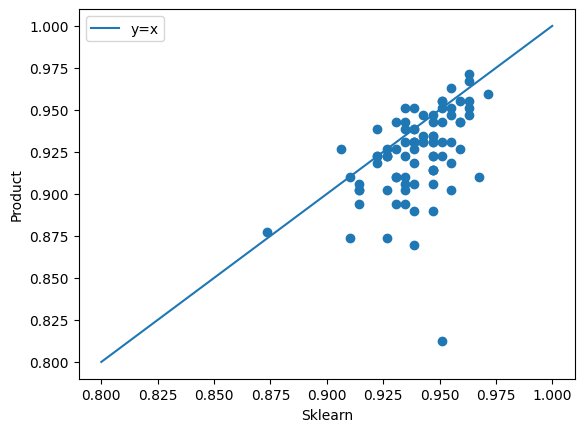

In [92]:
import matplotlib.pyplot as plt

plt.scatter(results["sklearn_rf"], results["product_rf"])
plt.xlabel("Sklearn")
plt.ylabel("Product")
plt.plot([0.8, 1], [0.8, 1], label="y=x")
plt.legend()

plt.show()

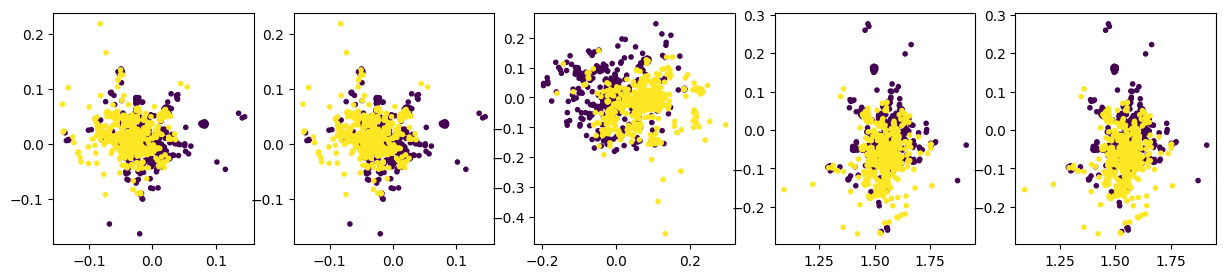

In [97]:
import embedders.visualization


fig, axs = plt.subplots(1, 5, figsize=(15, 3))
labels = y.detach().numpy()
for M, x, ax in zip(pm.P, pm.factorize(X), axs):
    if M.type == "E":
        x_plot = x
    elif M.type == "H":
        x_plot = embedders.visualization.hyperboloid_to_poincare(X)
    else:
        x_plot = embedders.visualization.S2_to_polar(X)
    x_plot = x_plot.detach().cpu().numpy()
    ax.scatter(x_plot[:, 0], x_plot[:, 1], c=y, s=9)